# Импортирование библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Загрузка данных

In [ ]:
try:
    df = pd.read_csv('/content/drive/MyDrive/30bitds/livejournal.csv', sep=',')
    print("Данные успешно загружены")
    print(f"Размерность данных: {df.shape}")
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")

Данные успешно загружены
Размерность данных: (124150, 9)


# Первичный осмотр данных

In [ ]:

display(df.tail(10))
display(df.info())

,_id,url,title,last_taken_ts,last_published_ts,last_updated_ts,extra.username,extra.description,type_id
0,680b5ea843627ed63472cdc9,https://vitas1917.livejournal.com,NaN,1747323601,1741202040,0,vitas1917,Записки рушанина,680b7390fee018c5a3ed7901
1,680b5ea843627ed63472cdca,https://masterok.livejournal.com,NaN,1747323601,1744788016,0,masterok,Хочу все знать,680b7390fee018c5a3ed7901
2,680b5ea843627ed63472cdcb,https://alexandr-rogers.livejournal.com,NaN,1747323601,1744723080,0,alexandr_rogers,NaN,680b7390fee018c5a3ed7901


,_id,url,title,last_taken_ts,last_published_ts,last_updated_ts,extra.username,extra.description,type_id
124147,680b5fd643627ed63474b2bc,https://icona-mat.livejournal.com,Ничего святого...,1747323589,1452608520,0,icona_mat,Ничего святого...,680b7390fee018c5a3ed7901
124148,680b5fd643627ed63474b2bd,https://baydonaut.livejournal.com,Байдологика,1747323589,1740651360,0,baydonaut,Байдологика,680b7390fee018c5a3ed7901
124149,680b5fd643627ed63474b2be,https://rip25.livejournal.com,rip25's Journal,1747323589,1296351360,0,rip25,veraugust,680b7390fee018c5a3ed7901



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124150 entries, 0 to 124149
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   _id                124150 non-null  object
 1   url                124150 non-null  object
 2   title              119205 non-null  object
 3   last_taken_ts      124150 non-null  int64 
 4   last_published_ts  124150 non-null  int64 
 5   last_updated_ts    124150 non-null  int64 
 6   extra.username     124150 non-null  object
 7   extra.description  81108 non-null   object
 8   type_id            124150 non-null  object
dtypes: int64(3), object(6)
memory usage: 8.5+ MB


None

## Первичный анализ данных

1. Датасет содержит 124150 записей и 9 столбцов
2. Основные столбцы:
   - `id` - идентификатор записи
   - `url` - URL блога
   - `title` - название блога (имеются пропуски)
   - временные метки (`last_taken_ts`, `last_published_ts`, `last_updated_ts`)
   - `extra.username` - имя пользователя
   - `extra.description` - описание блога (много пропусков)
   - `type_id` - тип записи

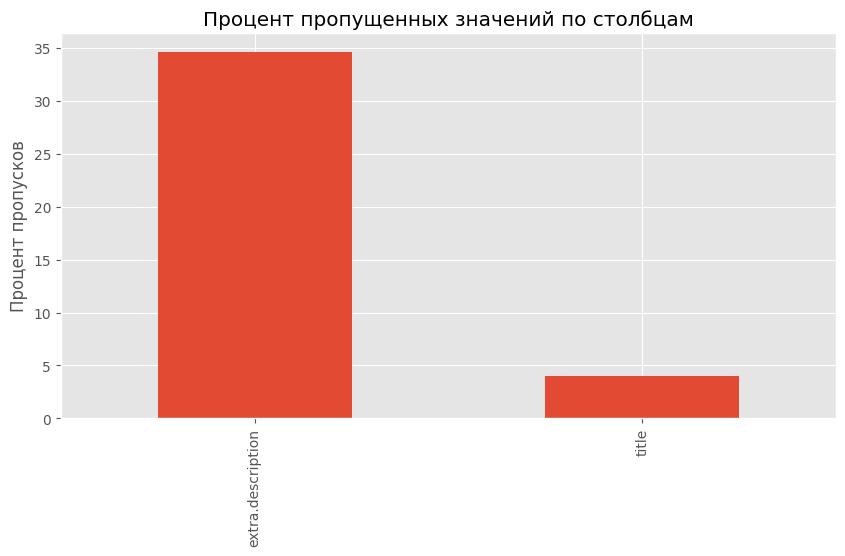

Количество пропусков по столбцам:


,Количество,Процент
extra.description,43042,34.669352
title,4945,3.983085
_id,0,0.000000
last_taken_ts,0,0.000000
url,0,0.000000
last_published_ts,0,0.000000
last_updated_ts,0,0.000000
extra.username,0,0.000000
type_id,0,0.000000


In [ ]:
missing_data = df.isna().sum().sort_values(ascending=False)
missing_percent = (df.isna().mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10,5))
missing_percent[missing_percent > 0].plot(kind='bar')
plt.title('Процент пропущенных значений по столбцам')
plt.ylabel('Процент пропусков')
plt.show()

print("Количество пропусков по столбцам:")
display(pd.concat([missing_data, missing_percent], axis=1,
                keys=['Количество', 'Процент']).sort_values('Количество', ascending=False))

## Анализ пропущенных данных

1. Столбец `extra.description` содержит 34.67% пропусков (43942 записи)
2. Столбец `title` содержит 3.98% пропусков (4945 записей)
3. Остальные столбцы не содержат пропусков

Рекомендации:
- Для текстового анализа можно заполнить пропуски в описаниях пустыми строками
- Пропущенные названия можно заменить на "Untitled"

In [ ]:
df['extra.description'] = df['extra.description'].fillna('')
df['title'] = df['title'].fillna('Untitled')
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество полных дубликатов: 0
Размер после удаления дубликатов: (124150, 9)


In [ ]:
ts_columns = [col for col in df.columns if '_ts' in col]

for col in ts_columns:
    new_col = col + '_datetime'
    df[new_col] = pd.to_datetime(df[col], unit='s', errors='coerce')
    df.drop(col, axis=1, inplace=True)
display(df[[col for col in df.columns if 'datetime' in col]].head())

Временные метки преобразованы:


,last_taken_ts_datetime,last_published_ts_datetime,last_updated_ts_datetime
0,2025-05-15 15:40:01,2025-03-05 19:14:00,1970-01-01
1,2025-05-15 15:40:01,2025-04-16 07:20:16,1970-01-01
2,2025-05-15 15:40:01,2025-04-15 13:18:00,1970-01-01
3,2025-05-15 15:40:01,2025-04-15 17:13:48,1970-01-01
4,2025-05-15 15:40:01,2025-04-15 17:13:44,1970-01-01


Вывод: Большинство блогов неактивны

# Анализ активности блогов

In [ ]:
current_date = datetime.now()
df['days_since_publish'] = (current_date - df['last_published_ts_datetime']).dt.days

def get_update_frequency(days):
    if days <= 7: return 'Daily'
    elif days <= 30: return 'Weekly'
    elif days <= 90: return 'Monthly'
    else: return 'Rare/Inactive'
df['update_frequency'] = df['days_since_publish'].apply(get_update_frequency)
plt.figure(figsize=(10,6))
df['update_frequency'].value_counts().plot(kind='bar', color='teal')
plt.title('Blog Update Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print("\nTop 5 most active blogs:")
display(df.sort_values('days_since_publish').head(5)[['url', 'days_since_publish']])
freq_dist = df['update_frequency'].value_counts(normalize=True).mul(100).round(2)
print("Распределение активности блогов:")
for label, pct in freq_dist.items():
    print(f"— {label}: {pct}%")

**Вывод:** большинство блогов неактивны

# Анализ описаний

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['то'] not in stop_words.
  warnings.warn(
/tmp/ipython-input-11-158255624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Word', data=keywords.head(10), palette='viridis')


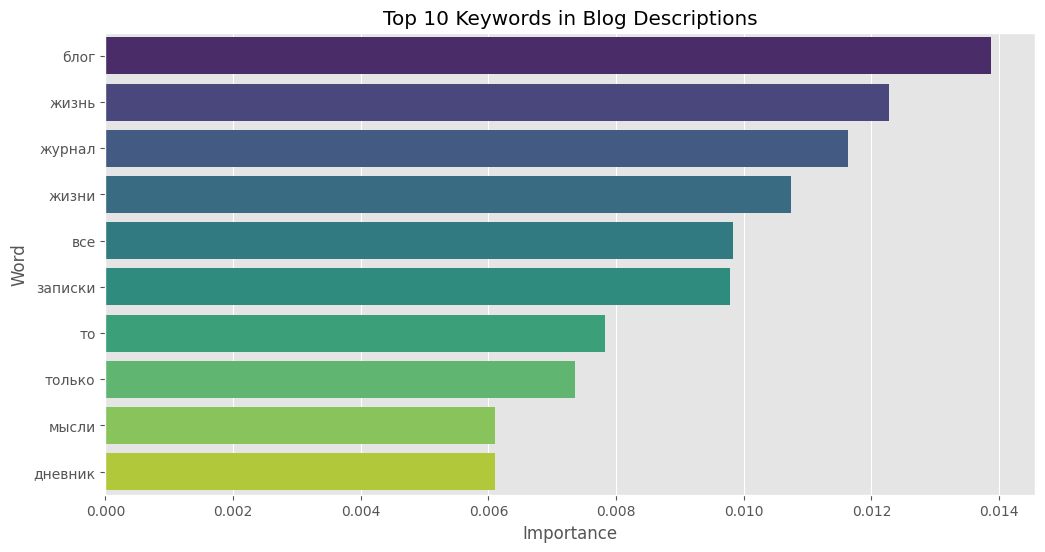

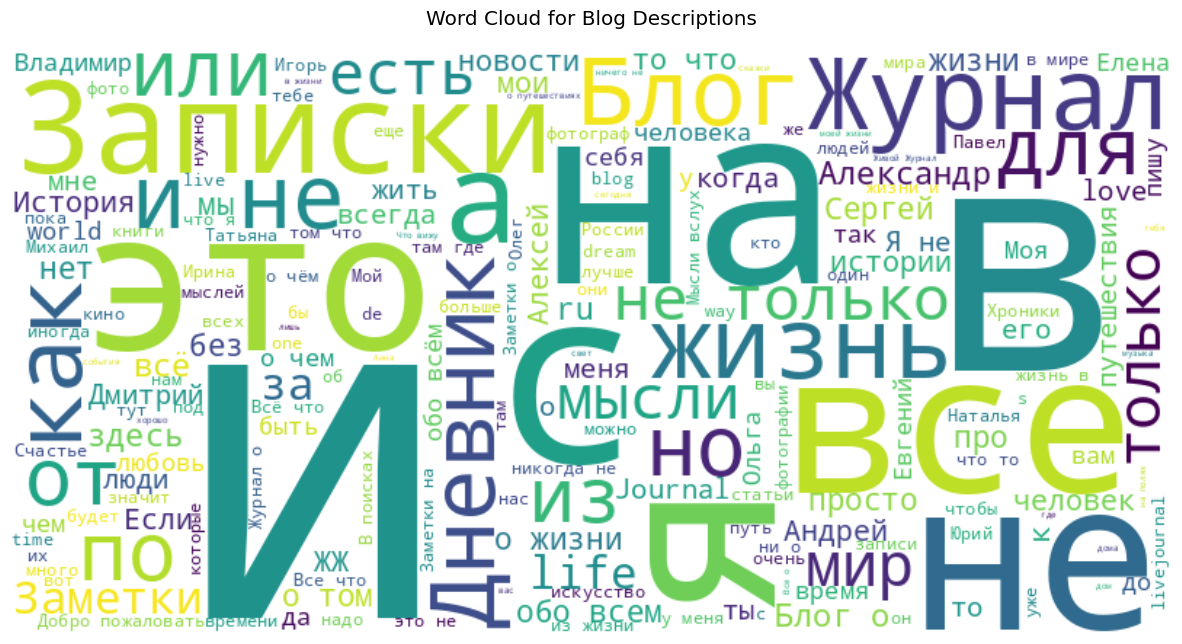

In [ ]:
vectorizer = TfidfVectorizer(max_features=20, stop_words=['это', 'как', 'для','не', 'на', 'что', 'по', 'the', 'и', 'с', 'от','из', 'то что', 'за', 'уже', 'же', 'И'])
X = vectorizer.fit_transform(df['extra.description'])
keywords = pd.DataFrame({
    'Word': vectorizer.get_feature_names_out(),
    'Importance': X.toarray().mean(axis=0)
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Word', data=keywords.head(10), palette='viridis')
plt.title('Top 10 Keywords in Blog Descriptions')
plt.show()
text = " ".join(desc for desc in df['extra.description'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Blog Descriptions', pad=20)
plt.show()

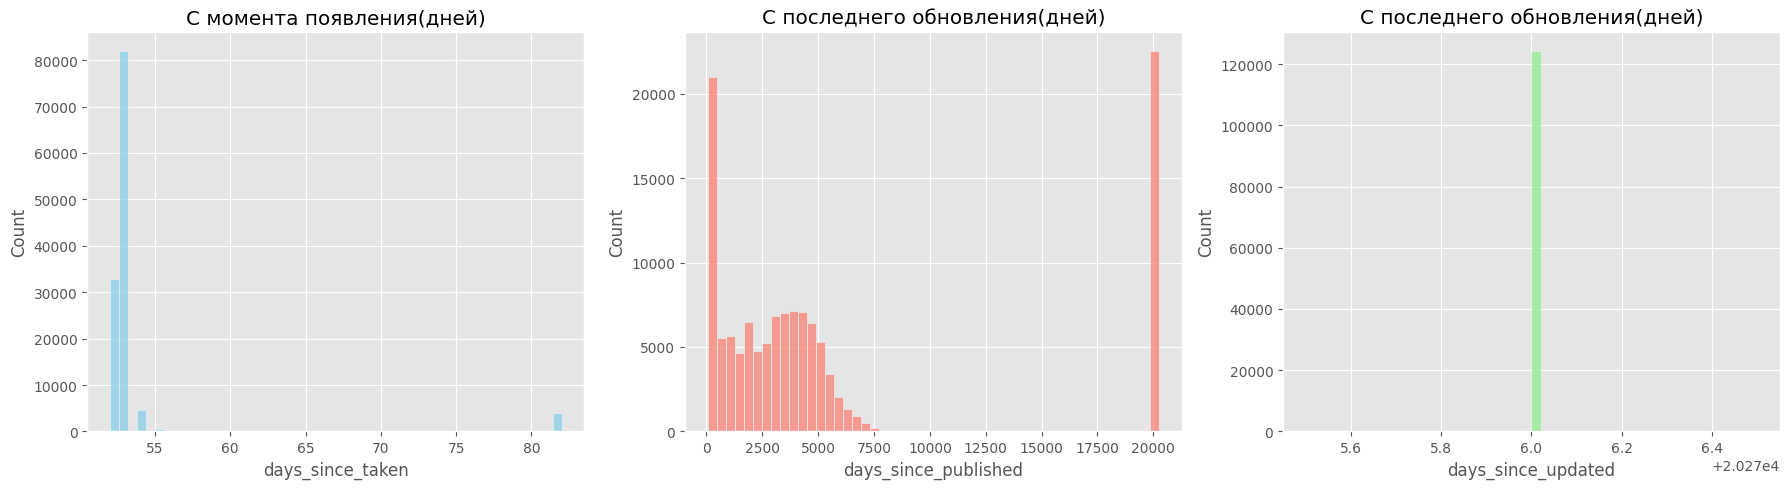

In [ ]:
df['is_active'] = (current_date - df['last_published_ts_datetime']).dt.days <= 30
fig, axes = plt.subplots(1, 3, figsize=(18,5))
df['days_since_taken'] = (current_date - df['last_taken_ts_datetime']).dt.days
sns.histplot(df['days_since_taken'], bins=50, ax=axes[0], color='skyblue')
axes[0].set_title('С момента появления(дней)')
df['days_since_published'] = (current_date - df['last_published_ts_datetime']).dt.days
sns.histplot(df['days_since_published'], bins=50, ax=axes[1], color='salmon')
axes[1].set_title('С последнего обновления(дней)')
df['days_since_updated'] = (current_date - df['last_updated_ts_datetime']).dt.days
sns.histplot(df['days_since_updated'], bins=50, ax=axes[2], color='lightgreen')
axes[2].set_title('С последнего обновления(дней)')
plt.tight_layout()
plt.show()

# Итоговые выводы и предложения по использованию данных

1. Наиболее значимые слова в описаниях блогов:
   - записки
   - блог
   - жизнь
   - путешествия
   - журнал
   - новости
2. Основные тематики блогов:
   - личные влоги
   - путешествия
   - новости

Вывод: Основные темы блогов связаны с повседневной жизнью, новостными обзорами и путешествиями, что может быть полезно для тематической классификации контента, для дальнейшего приенения в seo продвижении, поиска выгодных партнерских программ, так же данные могут помочь в обучении моделей рекомендательных систем.